In [1]:
# GPU settings
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True 
config.allow_soft_placement=True
sess = tf.Session(config=config)
set_session(sess)
keras.backend.clear_session()

Using TensorFlow backend.


In [2]:
# 資料集的前處理 , 將raccoon和kangaroo資料集轉為YOLO模型所需之格式

import numpy as np
import os

if not os.path.exists("train_labels.txt"):
    import xml.etree.ElementTree as ET # 載入能夠 Parse xml 文件的 library
    
    sets = ['train', 'val']
    classes = ["raccoon", "kangaroo"]
  
   # 將 annotation(.xml) 轉換到訓練時需要的資料形態(image_path, x_min, y_min, x_max, y_max, class_id)
    def convert_annotation(image_id, list_file):
        in_file = open('annotations/%s.xml'%(image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text    
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1: 
                continue
            cls_id = classes.index(cls)  # class index
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), 
                 int(xmlbox.find('ymin').text), 
                 int(xmlbox.find('xmax').text), 
                 int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
    
    # 取得 raccoon 和 kangaroo images_ids
    raccoon_ids = os.listdir('raccoon_dataset/images')
    kangaroo_ids = os.listdir('kangaroo/images')
    ids = raccoon_ids + kangaroo_ids
    ids = np.char.strip(ids, '.jpeg')

    # 將全部images的 80% 當訓練集資料
    train_ids = np.random.choice(ids, size=int(len(ids)*0.8), replace=False)
    val_ids = np.setdiff1d(ids, train_ids)
    
    # 將 ids 分別寫入 train.txt 和 val.txt
    t = open('train.txt', 'w')
    print('write train_ids to train.txt')
    for train_id in train_ids:
        t.write('%s' %(train_id))
        t.write('\n')
    t.close()
    
    v = open('val.txt', 'w')
    print('write val_ids to val.txt')
    for val_id in val_ids:
        v.write('%s' %(val_id))
        v.write('\n')
    v.close()
    
    # 將兩資料集的annotations 一併放入annotations資料夾
    if not os.path.exists('annotations'):
        !mkdir annotations
        !cp raccoon_dataset/annotations/* ./annotations
        !cp kangaroo/annots/* ./annotations
    
    # 將類別資料寫入 class.txt
    class_txt = open('class.txt', 'w')
    print("save class at class.txt")       
    for class_id in classes : 
        class_txt.write('%s' %(class_id))
        class_txt.write('\n')
    class_txt.close()
    
    # 寫入檔案
    for image_set in sets:  # train, val
        image_ids = open('%s.txt'%(image_set)).read().strip().split()      
        annotation_path = '%s_labels.txt'%(image_set)
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)

        for image_id in image_ids:
            if 'raccoon' in image_id :
                list_file.write('./raccoon_dataset/images/%s.jpg' %(image_id))
            else :
                list_file.write('./kangaroo/images/%s.jpg' %(image_id))  
            convert_annotation(image_id, list_file)
            list_file.write('\n')
        list_file.close()

In [3]:
# 將 YOLOv3 weights 轉換為 keras 可接受的格式
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training ...")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5")
    print("Done.")
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [4]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [5]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [6]:
# 避免訓練時發生 error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
annotation_path_train = 'train_labels.txt' # 轉換好格式的 train 標註檔案
annotation_path_val = 'val_labels.txt' # 轉換好格式的 val 標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, 
                              anchors, 
                              num_classes,
                              freeze_body=2, 
                              weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, 
                         anchors, 
                         num_classes,
                         freeze_body=2, 
                         weights_path='model_data/yolo_weights.h5')

logging = TensorBoard(log_dir=log_dir)

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', 
                             save_weights_only=True, 
                             save_best_only=True, 
                             period=30)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

with open(annotation_path_train) as f:
    lines_train = f.readlines()
with open(annotation_path_val) as f:
    lines_val = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines_train)
np.random.shuffle(lines_val)
np.random.seed(None)
num_train = len(lines_train)  # 訓練資料(80%)
num_val = len(lines_val)      # 驗證資料(20%)

# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model_1= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
                                 steps_per_epoch = max(1, num_train//batch_size),
                                 validation_data = data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
                                 validation_steps = max(1, num_val//batch_size),
                                 epochs = 50,
                                 initial_epoch = 0,
                                 callbacks = [logging, checkpoint, reduce_lr])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 5 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    hist_model= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
                                    steps_per_epoch = max(1, num_train//batch_size),
                                    validation_data = data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
                                    validation_steps = max(1, num_val//batch_size),
                                    epochs = 100,
                                    initial_epoch = 50,
                                    callbacks = [logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')









Create YOLOv3 model with 9 anchors and 2 classes.


/home/shinfu/anaconda3/envs/yolo_v1/lib/python3.6/site-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/home/shinfu/anaconda3/envs/yolo_v1/lib/python3.6/site-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/home/shinfu/anaconda3/envs/yolo_v1/lib/python3.6/site-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/home/shinfu/anaconda3/envs/yolo_v1/lib/python3.6/site-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/home/shinfu/anaconda3/envs/yolo_v1/lib/python3.6/

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 282 samples, val on 71 samples, with batch size 16.




Epoch 1/50
17/17 [==============================] - 25s 1s/step - loss: 4949.9007 - val_loss: 1824.8292

Epoch 2/50
17/17 [==============================] - 18s 1s/step - loss: 894.7039 - val_loss: 537.9285
Epoch 3/50
17/17 [==============================] - 18s 1s/step - loss: 351.5298 - val_loss: 293.3521
Epoch 4/50
17/17 [==============================] - 16s 960ms/step - loss: 226.9518 - val_loss: 205.6632
Epoch 5/50
17/17 [==============================] - 15s 908ms/step - loss: 171.0634 - val_loss: 158.6370
Epoch 6/50
17/17 [==============================] - 17s 983ms/step - loss: 142.6139 - val_loss: 137.4581
Epoch 7/50
17/17 [==============================] - 16s 925ms/step - loss: 118.4131 - val_loss: 119.1124
Epoch 8/50
17/17 [==

Epoch 61/100
56/56 [==============================] - 29s 523ms/step - loss: 14.7516 - val_loss: 18.1854

Epoch 00061: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 62/100
56/56 [==============================] - 29s 525ms/step - loss: 14.2440 - val_loss: 15.5169
Epoch 63/100
56/56 [==============================] - 29s 524ms/step - loss: 13.8850 - val_loss: 16.9921
Epoch 64/100
56/56 [==============================] - 30s 531ms/step - loss: 14.1554 - val_loss: 15.3236
Epoch 65/100
56/56 [==============================] - 30s 532ms/step - loss: 13.5611 - val_loss: 15.9721
Epoch 66/100
56/56 [==============================] - 30s 534ms/step - loss: 13.4755 - val_loss: 15.8294
Epoch 67/100
56/56 [==============================] - 30s 531ms/step - loss: 13.6020 - val_loss: 15.1598
Epoch 68/100
56/56 [==============================] - 29s 523ms/step - loss: 13.5671 - val_loss: 15.3121
Epoch 69/100
56/56 [==============================] - 30s 534ms/step - loss: 13

分析

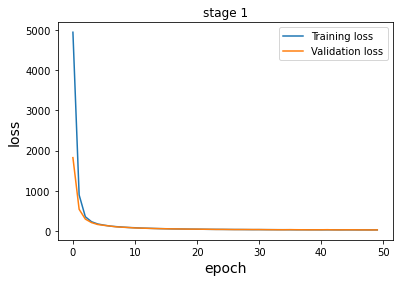

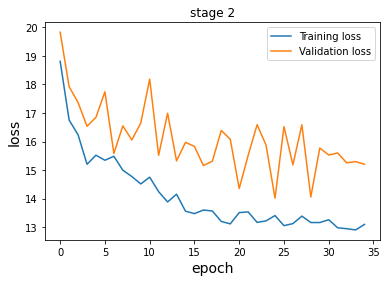

In [10]:
# draw the change of train_loss and val_loss durning training
import matplotlib.pyplot as plt
%matplotlib inline

# stage 1 training
plt.title('stage 1') # 對應至訓練中 unfreeze 前的階段 i.e. 前50次 epoch
plt.xlabel("epoch", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.plot(model_1.history["loss"], label="Training loss")
plt.plot(model_1.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')
plt.show()

# strage 2 training
plt.title('stage 2') # 對應至訓練中 unfreeze 後的階段 i.e. 後50次 epoch
plt.xlabel("epoch", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.plot(hist_model.history["loss"], label="Training loss")
plt.plot(hist_model.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')
plt.show()

Test

In [15]:
# 各隨機抽5張image當作測試資料
import os, random, shutil
 
def createTestData(file_path, tar_path):
    source_path = os.listdir(file_path)
    # 隨機抽取 5張 image
    sample = random.sample(source_path, 5)
    for name in sample:
        shutil.copyfile(file_path+name, tar_path+name)
    print("Create test data successfully.")

createTestData(file_path='raccoon_dataset/images/', tar_path='./test/')
createTestData(file_path='kangaroo/images/', tar_path='./test/')

Create test data successfully.
Create test data successfully.


logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (87, 5) (557, 334)
2.7070341109993024


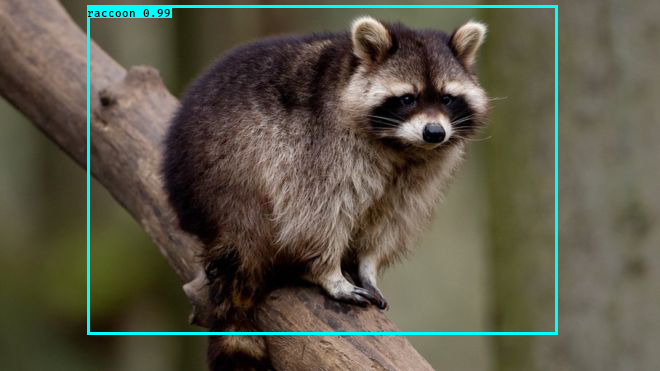

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (253, 85) (538, 425)
0.053206345000944566


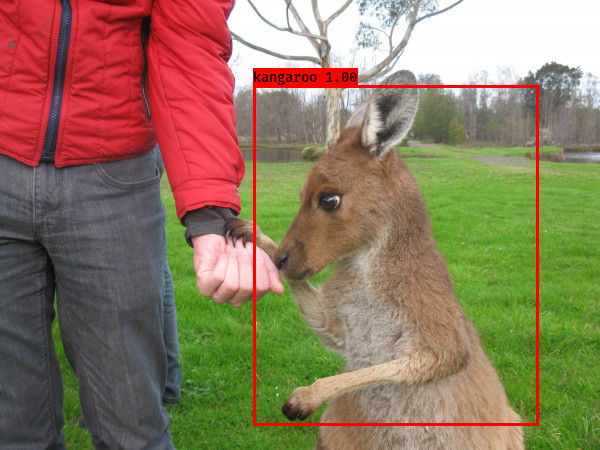

(416, 416, 3)
Found 7 boxes for img
kangaroo 0.11 (83, 261) (113, 311)
kangaroo 0.13 (505, 340) (744, 467)
kangaroo 0.14 (70, 261) (98, 309)
kangaroo 0.25 (207, 217) (393, 400)
kangaroo 0.33 (57, 252) (142, 324)
kangaroo 0.73 (450, 370) (740, 434)
kangaroo 0.81 (260, 236) (343, 380)
0.06688164400111418


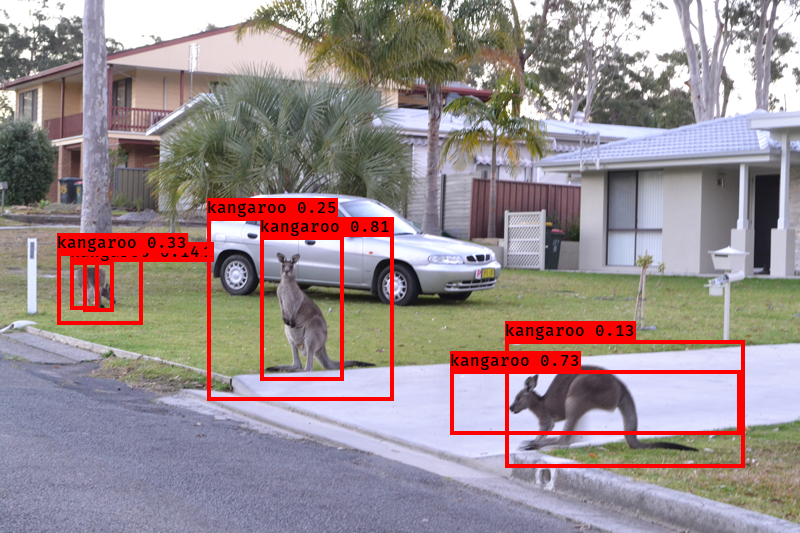

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.88 (203, 110) (303, 439)
kangaroo 0.93 (294, 169) (441, 427)
0.05181190199982666


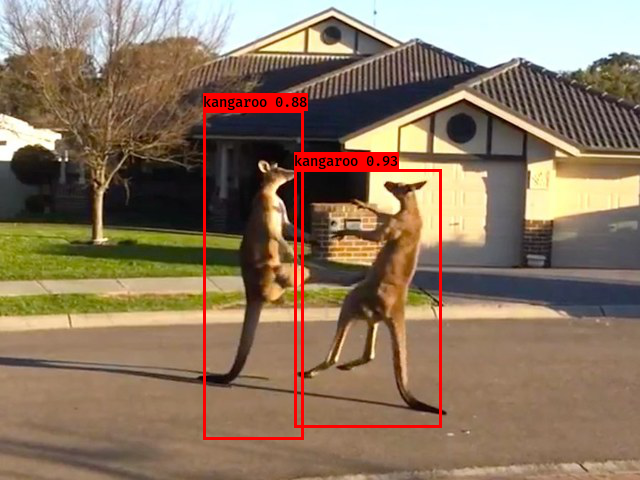

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (65, 8) (219, 159)
0.05848366600002919


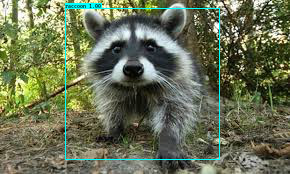

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (302, 84) (514, 268)
0.05262898200089694


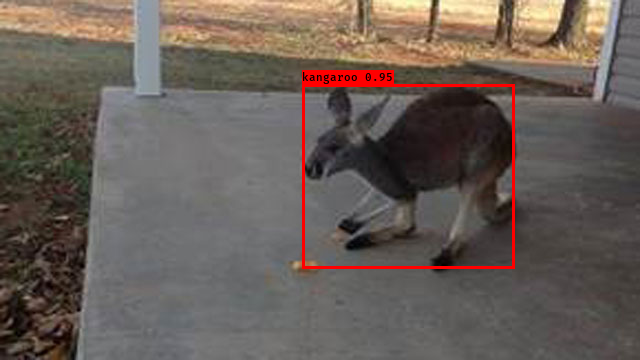

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (304, 23) (800, 577)
0.0818769199995586


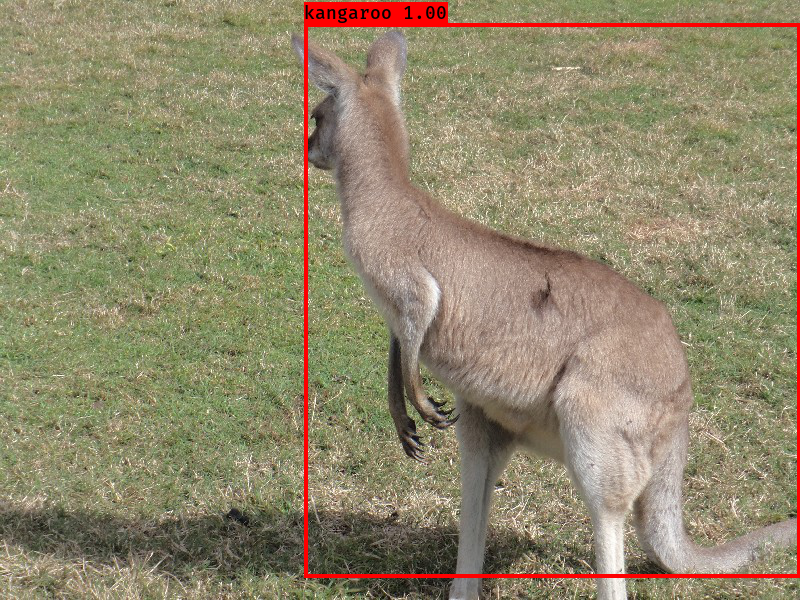

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (76, 83) (291, 264)
0.04806076299973938


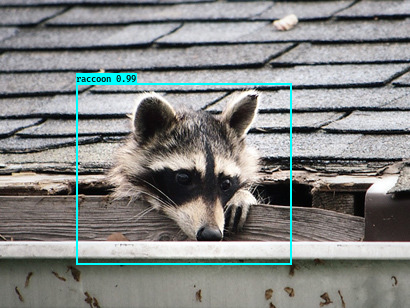

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (13, 0) (164, 180)
0.06124264299978677


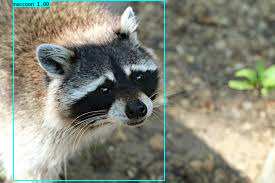

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 2) (182, 226)
0.054012507000152254


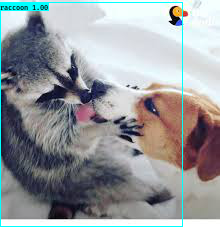

In [16]:
# 使用 YOLOv3 偵測 10張 images 並顯示結果
from yolo import YOLO

yolo_model = YOLO(model_path = log_dir + 'trained_weights_final.h5', classes_path='class.txt')

from PIL import Image
from IPython import display

for img in os.listdir('test'):
    image = Image.open(os.path.join('test/', img))  # read testing images
    r_image = yolo_model.detect_image(image)  #  run yolo detect and save the return image in r_image
    display.display(r_image)  # display r_image , see if images have bboxs

In [23]:
# detect videos
from yolo import YOLO
import numpy as np
import time
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

log_dir = 'logs/000/' # 訓練好的模型要儲存的路徑
classes_path = 'class.txt'

yolo_model = YOLO(model_path=log_dir+'trained_weights_final.h5', classes_path=classes_path)

def detect_video(yolo, video_path, output_path=""):
    import cv2
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise IOError("Couldn't open webcam or video!")
        
    # get video's information
    video_FourCC = int(video.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')  # 指定 video 編碼方式(mp4)
    video_fps = video.get(cv2.CAP_PROP_FPS)  # 總共有多少 frames
    video_size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),   # 每個 frame 的寬
                  int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))  # 每個 frame 的高
    
    # set video output
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    
    # init
    video_count = 0  
    video_playtime = []  
    
    while True:
        return_value, frame = video.read() # 讀取每個 frame
        video_count+=1
        
        # 先把每個 frame 分開偵測，再把偵測完的 frames 串接回影片，最後輸出偵測好的影片
        if return_value == True: 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)  # 直接使用 yolo.py 的 detect_image 函式
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), 
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), 
                        thickness=2)
            if isOutput:
                out.write(result)
        else:  
            break
            
    # 釋放資源
    video.release()  # release input video resource
    out.release()  # release output video resource
    
    return video_playtime, video_count

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [26]:
# detect Kangaroo.mp4

video_playtime, video_count = detect_video(yolo_model, 
                                           video_path='video/Kangaroo.mp4', 
                                           output_path="video/Kangaroo_out.mp4")
# total frames
print('\nKangaroo.mp4 total frames:', video_count)  

# average fps
avg_fps = 1/np.mean(video_playtime)
print("Kangaroo.mp4 avg fps: %.3f" % avg_fps)

(416, 416, 3)
Found 2 boxes for img
raccoon 0.48 (355, 0) (1280, 720)
raccoon 0.67 (305, 0) (774, 699)
2.7610609709990968
(416, 416, 3)
Found 2 boxes for img
raccoon 0.47 (355, 0) (1280, 720)
raccoon 0.67 (305, 0) (774, 698)
0.15017829799762694
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (360, 0) (1276, 720)
raccoon 0.81 (305, 0) (767, 702)
0.07203023400143138
(416, 416, 3)
Found 3 boxes for img
raccoon 0.18 (0, 0) (511, 720)
raccoon 0.41 (294, 0) (782, 720)
raccoon 0.53 (336, 0) (1280, 720)
0.05519927000204916
(416, 416, 3)
Found 2 boxes for img
raccoon 0.47 (375, 0) (1257, 720)
raccoon 0.50 (303, 0) (754, 720)
0.05877848200179869
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (301, 0) (771, 707)
raccoon 0.58 (372, 0) (1257, 720)
0.06476988299982622
(416, 416, 3)
Found 2 boxes for img
raccoon 0.21 (281, 0) (798, 683)
raccoon 0.66 (372, 0) (1256, 720)
0.05738848100008909
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (308, 0) (1202, 720)
0.05221565499959979
(416, 416, 3)
Found

Found 1 boxes for img
kangaroo 0.13 (342, 121) (529, 606)
0.053719969000667334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.13 (343, 120) (530, 606)
0.06102047699823743
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.13 (343, 119) (530, 607)
0.05982024599870783
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.14 (344, 126) (532, 602)
0.06832261100134929
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.16 (342, 127) (531, 598)
0.05353771400041296
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.14 (344, 123) (531, 605)
0.05285401500077569
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.15 (344, 119) (530, 611)
0.05670028100212221
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.15 (343, 122) (531, 608)
0.06587630200010608
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.17 (341, 123) (533, 605)
0.054128567997395294
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.16 (341, 124) (534, 605)
0.05611759000021266
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.16 (342, 122) (533, 606)
0.07018570799846202


Found 3 boxes for img
kangaroo 0.12 (533, 0) (1103, 712)
raccoon 0.11 (296, 0) (1235, 720)
raccoon 0.93 (507, 28) (1011, 668)
0.10397073599961004
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.13 (539, 0) (1097, 720)
raccoon 0.90 (511, 23) (1011, 666)
0.10704647500097053
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.19 (541, 0) (1094, 720)
raccoon 0.86 (509, 27) (1013, 665)
0.09788803099945653
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.19 (542, 0) (1093, 720)
raccoon 0.85 (508, 22) (1014, 666)
0.09899927299920819
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.20 (542, 0) (1093, 720)
raccoon 0.85 (508, 22) (1014, 666)
0.06029235599999083
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.18 (541, 0) (1093, 720)
raccoon 0.86 (508, 25) (1015, 666)
0.06250206400000025
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (13, 38) (1032, 645)
0.07430985999963013
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (9, 36) (1033, 656)
0.06575000600059866
(416, 416, 3)
Found 1 boxes for img
kangaro

Found 2 boxes for img
kangaroo 0.58 (37, 0) (836, 680)
raccoon 0.55 (0, 41) (939, 627)
0.056943973002489656
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.29 (27, 0) (842, 645)
raccoon 0.79 (27, 0) (842, 645)
0.07247297800131491
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.48 (6, 0) (853, 644)
raccoon 0.64 (0, 0) (872, 598)
0.05450512999959756
(416, 416, 3)
Found 0 boxes for img
0.11067554200053564
(416, 416, 3)
Found 0 boxes for img
0.04966087399952812
(416, 416, 3)
Found 0 boxes for img
0.05454259700127295
(416, 416, 3)
Found 0 boxes for img
0.06803758699970786
(416, 416, 3)
Found 0 boxes for img
0.057123257996863686
(416, 416, 3)
Found 1 boxes for img
raccoon 0.14 (3, 2) (1264, 685)
0.05155970600026194
(416, 416, 3)
Found 0 boxes for img
0.05130398300025263
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (82, 0) (1162, 562)
0.055446228998334846
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (80, 0) (1164, 561)
0.054240713998297
(416, 416, 3)
Found 1 boxes for img
raccoon 0.12 (

kangaroo 0.87 (97, 63) (321, 410)
raccoon 0.10 (684, 380) (941, 705)
raccoon 0.29 (383, 95) (670, 416)
raccoon 0.39 (869, 161) (1047, 583)
0.061737610998534365
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.15 (684, 381) (941, 703)
kangaroo 0.87 (97, 56) (321, 418)
raccoon 0.36 (866, 167) (1050, 575)
raccoon 0.36 (374, 103) (673, 399)
0.05995206200168468
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.11 (686, 378) (938, 704)
kangaroo 0.87 (101, 50) (317, 425)
raccoon 0.13 (686, 378) (938, 704)
raccoon 0.30 (866, 160) (1052, 584)
raccoon 0.43 (374, 107) (672, 383)
0.07013302999985171
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.11 (686, 380) (939, 702)
kangaroo 0.87 (102, 49) (317, 427)
raccoon 0.13 (686, 380) (939, 702)
raccoon 0.31 (868, 163) (1051, 581)
raccoon 0.43 (374, 104) (672, 387)
0.07824180500028888
(416, 416, 3)
Found 7 boxes for img
kangaroo 0.15 (373, 117) (682, 379)
kangaroo 0.20 (693, 391) (932, 695)
kangaroo 0.89 (98, 57) (324, 415)
raccoon 0.11 (467, 195) (655, 347)


Found 5 boxes for img
kangaroo 0.15 (858, 228) (1051, 514)
kangaroo 0.76 (573, 380) (921, 708)
kangaroo 0.78 (77, 155) (384, 429)
raccoon 0.19 (855, 137) (1074, 606)
raccoon 0.22 (389, 137) (555, 324)
0.06891811099922052
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.12 (857, 227) (1051, 514)
kangaroo 0.66 (68, 142) (385, 441)
kangaroo 0.70 (570, 377) (917, 715)
raccoon 0.16 (68, 142) (385, 441)
raccoon 0.22 (858, 142) (1071, 603)
raccoon 0.26 (378, 114) (559, 353)
0.05829357399852597
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.19 (852, 237) (1052, 498)
kangaroo 0.66 (66, 139) (387, 442)
kangaroo 0.67 (576, 384) (904, 709)
raccoon 0.15 (66, 139) (387, 442)
raccoon 0.25 (855, 154) (1070, 587)
raccoon 0.33 (398, 138) (549, 327)
0.06964449000224704
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.20 (851, 238) (1051, 497)
kangaroo 0.66 (66, 139) (387, 442)
kangaroo 0.67 (576, 384) (902, 708)
raccoon 0.15 (66, 139) (387, 442)
raccoon 0.24 (854, 154) (1071, 587)
raccoon 0.32 (398, 139) (54

Found 2 boxes for img
kangaroo 0.11 (556, 357) (905, 501)
kangaroo 0.40 (1022, 425) (1182, 564)
0.06730514700029744
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.26 (1025, 418) (1200, 559)
kangaroo 0.46 (643, 355) (853, 502)
0.06165280300047016
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.13 (17, 0) (146, 113)
kangaroo 0.15 (1005, 421) (1237, 553)
kangaroo 0.62 (647, 366) (877, 497)
0.06353241100077867
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (1058, 409) (1240, 547)
kangaroo 0.58 (698, 354) (897, 534)
0.07260624999980791
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (1054, 408) (1241, 550)
kangaroo 0.50 (690, 347) (903, 545)
0.05412277999857906
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (708, 381) (917, 510)
0.059622687000228325
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (699, 382) (961, 516)
0.053667718999349745
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (753, 362) (942, 515)
0.05489161700097611
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.24 (79

Found 7 boxes for img
kangaroo 0.13 (3, 191) (134, 373)
kangaroo 0.17 (406, 370) (914, 720)
kangaroo 0.40 (356, 91) (516, 367)
kangaroo 0.87 (0, 112) (156, 446)
raccoon 0.12 (381, 97) (520, 352)
raccoon 0.14 (668, 205) (889, 498)
raccoon 0.20 (1012, 434) (1257, 717)
0.06221177900079056
(416, 416, 3)
Found 7 boxes for img
kangaroo 0.13 (3, 191) (134, 373)
kangaroo 0.17 (406, 370) (914, 720)
kangaroo 0.40 (356, 91) (516, 367)
kangaroo 0.87 (0, 111) (156, 446)
raccoon 0.11 (381, 97) (520, 352)
raccoon 0.14 (668, 205) (889, 498)
raccoon 0.20 (1012, 434) (1257, 717)
0.06208627600062755
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.84 (0, 111) (160, 447)
raccoon 0.15 (1016, 429) (1256, 720)
raccoon 0.16 (677, 204) (883, 504)
raccoon 0.32 (354, 95) (515, 363)
0.06746606199885719
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.14 (536, 397) (914, 689)
kangaroo 0.28 (354, 91) (514, 321)
kangaroo 0.86 (0, 105) (164, 458)
raccoon 0.13 (1018, 430) (1254, 720)
raccoon 0.33 (361, 95) (505, 350)
0.07

Found 1 boxes for img
raccoon 0.86 (616, 0) (1016, 714)
0.06314118600130314
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (617, 0) (1013, 715)
0.05645951599944965
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (617, 0) (1015, 713)
raccoon 0.55 (617, 0) (1015, 713)
0.05323177000173018
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (619, 0) (1012, 711)
raccoon 0.54 (619, 0) (1012, 711)
0.05625848600175232
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.20 (620, 0) (1014, 713)
raccoon 0.73 (620, 0) (1014, 713)
0.05763519199899747
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (619, 0) (1012, 712)
raccoon 0.53 (619, 0) (1012, 712)
0.05782449199978146
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.24 (619, 0) (1014, 714)
raccoon 0.68 (619, 0) (1014, 714)
0.06442203000187874
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (622, 6) (1012, 706)
raccoon 0.39 (622, 6) (1012, 706)
0.06427314699976705
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (622, 0) (1022, 714)
raccoon 0.63 

Found 5 boxes for img
kangaroo 0.19 (824, 311) (1015, 483)
kangaroo 0.68 (226, 343) (834, 611)
kangaroo 0.69 (683, 301) (1020, 553)
raccoon 0.16 (226, 343) (834, 611)
raccoon 0.19 (25, 297) (430, 617)
0.06514027199955308
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.20 (800, 308) (1020, 467)
kangaroo 0.47 (41, 285) (395, 645)
kangaroo 0.70 (694, 289) (1022, 551)
kangaroo 0.86 (113, 234) (804, 695)
raccoon 0.12 (225, 315) (814, 624)
0.05937706700206036
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.50 (3, 285) (422, 670)
kangaroo 0.86 (690, 302) (1022, 542)
kangaroo 0.94 (163, 244) (773, 680)
0.05574657999750343
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.61 (35, 283) (327, 680)
kangaroo 0.91 (664, 308) (1029, 546)
kangaroo 0.94 (208, 238) (752, 650)
0.05786028399961651
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.60 (35, 283) (327, 679)
kangaroo 0.91 (665, 310) (1030, 544)
kangaroo 0.94 (209, 237) (752, 649)
0.05955016000007163
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (2

Found 5 boxes for img
kangaroo 0.45 (455, 287) (806, 542)
kangaroo 0.57 (33, 273) (461, 608)
kangaroo 0.81 (787, 303) (1254, 637)
raccoon 0.15 (726, 283) (1280, 661)
raccoon 0.51 (439, 240) (826, 534)
0.05700353599968366
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.78 (421, 290) (831, 535)
kangaroo 0.84 (21, 271) (454, 586)
raccoon 0.17 (410, 263) (851, 526)
0.05378578100135201
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.79 (25, 254) (453, 605)
kangaroo 0.84 (412, 312) (888, 519)
raccoon 0.27 (2, 148) (505, 613)
0.05692293199899723
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.57 (41, 242) (453, 600)
kangaroo 0.96 (456, 322) (759, 514)
raccoon 0.29 (8, 183) (519, 574)
0.059061209998617414
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.58 (41, 242) (453, 600)
kangaroo 0.96 (456, 322) (759, 514)
raccoon 0.29 (8, 184) (519, 573)
0.07037944499825244
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (8, 178) (525, 571)
kangaroo 0.96 (454, 323) (760, 524)
0.057166203998349374
(416, 416

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (618, 145) (1074, 612)
0.06350137700064806
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (618, 139) (1069, 614)
0.058022633002110524
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.83 (624, 140) (1069, 618)
raccoon 0.10 (624, 140) (1069, 618)
0.05714339399855817
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (630, 144) (1063, 617)
0.0649442479989375
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (630, 144) (1063, 617)
0.05784936499912874
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (632, 142) (1062, 617)
0.05090245599785703
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (621, 138) (1068, 614)
0.0638194029997976
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (616, 134) (1066, 622)
0.056635351000295486
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (610, 132) (1065, 623)
0.05446246200153837
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (610, 132) (1065, 623)
0.07177389199932804
(416, 416, 3)
Found 1 boxes for im

Found 1 boxes for img
raccoon 0.54 (610, 0) (1254, 720)
0.0606969280015619
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (609, 0) (1253, 719)
0.0670930189990031
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (619, 0) (1248, 720)
0.05884765100199729
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (666, 0) (1233, 720)
0.0655838880011288
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (684, 0) (1220, 720)
0.0556531719994382
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (780, 0) (1275, 720)
0.060044112000468886
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (778, 0) (1277, 720)
0.052620702001149766
(416, 416, 3)
Found 0 boxes for img
0.05181023600016488
(416, 416, 3)
Found 0 boxes for img
0.051056860997050535
(416, 416, 3)
Found 0 boxes for img
0.05240937800044776
(416, 416, 3)
Found 0 boxes for img
0.059437297997646965
(416, 416, 3)
Found 0 boxes for img
0.05822008100221865
(416, 416, 3)
Found 0 boxes for img
0.05887050800083671
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39

Found 2 boxes for img
kangaroo 0.88 (52, 106) (1221, 621)
raccoon 0.36 (60, 102) (1078, 627)
0.053974384998582536
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.87 (50, 106) (1224, 623)
raccoon 0.37 (59, 102) (1080, 627)
0.06295933999717818
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.48 (0, 97) (1280, 720)
raccoon 0.79 (21, 46) (1123, 673)
0.05622043100083829
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (0, 102) (1280, 720)
raccoon 0.62 (0, 61) (1276, 664)
0.053545717000815785
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (0, 83) (1280, 720)
raccoon 0.76 (0, 71) (1280, 664)
0.06196168799942825
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.90 (0, 135) (1280, 717)
raccoon 0.55 (7, 76) (1138, 653)
0.05954397200184758
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (0, 136) (1275, 717)
raccoon 0.53 (15, 75) (1129, 656)
0.056405155002721585
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (0, 142) (1280, 713)
raccoon 0.19 (43, 69) (1102, 659)
0.056991837998793926
(416, 416, 

Found 3 boxes for img
kangaroo 0.79 (0, 66) (1280, 644)
raccoon 0.14 (0, 109) (1280, 720)
raccoon 0.25 (33, 0) (1218, 597)
0.06672546399931889
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.78 (0, 64) (1280, 646)
raccoon 0.14 (0, 108) (1280, 720)
raccoon 0.27 (37, 0) (1214, 597)
0.06035510600122507
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.70 (0, 58) (1280, 640)
raccoon 0.36 (0, 58) (1280, 640)
0.06130660500275553
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 88) (1280, 599)
0.05598742999791284
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 83) (1280, 603)
0.05180386199936038
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (0, 32) (1280, 631)
raccoon 0.19 (59, 71) (1099, 611)
0.0636842189996969
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (0, 36) (1280, 627)
raccoon 0.15 (70, 75) (1088, 606)
0.058716380000987556
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 33) (1280, 638)
0.05287553800008027
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.22 (236, 44)

Found 1 boxes for img
kangaroo 0.99 (4, 0) (1102, 572)
0.05893503599872929
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (9, 1) (1101, 549)
0.05486943500000052
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (12, 1) (1099, 549)
0.05271255200204905
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (44, 0) (1078, 552)
0.05723847300032503
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (32, 0) (1095, 576)
0.05364915500103962
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (105, 0) (1031, 533)
0.050857169000664726
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (71, 0) (1055, 613)
0.05356207099976018
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (74, 0) (1054, 611)
0.0621226880030008
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.96 (49, 0) (1076, 549)
raccoon 0.26 (0, 0) (1196, 720)
0.052635951000411296
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.94 (83, 0) (1047, 596)
raccoon 0.27 (0, 0) (1174, 720)
0.05310090499915532
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.12 (948, 338) (994, 490)
kangaroo 0.13 (632, 387) (674, 599)
kangaroo 0.24 (626, 444) (680, 545)
kangaroo 0.38 (839, 410) (918, 590)
0.0617433980005444
(416, 416, 3)
Found 7 boxes for img
kangaroo 0.11 (505, 467) (657, 534)
kangaroo 0.12 (552, 445) (601, 544)
kangaroo 0.12 (928, 370) (1025, 470)
kangaroo 0.12 (947, 335) (994, 496)
kangaroo 0.24 (1005, 482) (1078, 601)
kangaroo 0.64 (819, 441) (931, 589)
kangaroo 0.69 (632, 428) (697, 546)
0.06387472999995225
(416, 416, 3)
Found 7 boxes for img
kangaroo 0.10 (992, 461) (1081, 615)
kangaroo 0.11 (548, 427) (603, 563)
kangaroo 0.12 (508, 456) (652, 540)
kangaroo 0.12 (951, 351) (992, 525)
kangaroo 0.13 (929, 385) (1026, 467)
kangaroo 0.79 (638, 418) (705, 547)
kangaroo 0.83 (817, 453) (929, 590)
0.06370352099838783
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.14 (498, 456) (659, 540)
kangaroo 0.14 (545, 416) (603, 570)
kangaroo 0.16 (962, 465) (1077, 602)
kangaroo 0.50 (801, 428) (943, 608)

Found 4 boxes for img
kangaroo 0.10 (752, 576) (794, 704)
kangaroo 0.25 (975, 390) (1078, 603)
kangaroo 0.34 (403, 392) (517, 548)
kangaroo 0.73 (764, 407) (833, 554)
0.07069130899981246
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.12 (997, 421) (1079, 607)
kangaroo 0.41 (409, 398) (515, 541)
kangaroo 0.58 (768, 425) (837, 558)
0.059366989000409376
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (421, 399) (512, 544)
kangaroo 0.79 (774, 426) (847, 565)
0.05809775600209832
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.17 (898, 317) (980, 619)
kangaroo 0.20 (1004, 466) (1127, 604)
kangaroo 0.34 (430, 415) (506, 543)
kangaroo 0.62 (779, 454) (849, 579)
0.06892438200156903
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.19 (904, 421) (973, 573)
kangaroo 0.42 (1017, 472) (1126, 620)
kangaroo 0.62 (439, 433) (508, 546)
kangaroo 0.71 (782, 450) (849, 590)
0.06162011199921835
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.19 (904, 421) (973, 573)
kangaroo 0.42 (1017, 472) (1126, 620)
kanga

0.052525652001349954
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (32, 0) (1262, 713)
0.057032726999750594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (27, 0) (1268, 716)
0.05623492300219368
(416, 416, 3)
Found 1 boxes for img
raccoon 0.24 (103, 0) (1186, 597)
0.05761098199945991
(416, 416, 3)
Found 1 boxes for img
raccoon 0.25 (74, 0) (1222, 695)
0.05620269300197833
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (28, 0) (1259, 689)
0.05268776799857733
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (68, 0) (1218, 563)
0.05647176400088938
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (65, 0) (1222, 568)
0.05429501400067238
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (99, 0) (1185, 553)
0.056228892997751245
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (98, 0) (1186, 553)
0.06377221299771918
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (130, 0) (1153, 565)
0.059329132996936096
(416, 416, 3)
Found 1 boxes for img
raccoon 0.16 (133, 0) (1156, 573)
0.057965997999

Found 1 boxes for img
raccoon 0.65 (0, 0) (1280, 720)
0.06598784999732743
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (0, 0) (1280, 720)
0.060584532999200746
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 0) (1280, 720)
0.05777730100089684
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1280, 716)
0.05718036699909135
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 0) (1280, 720)
0.06439652200060664
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (0, 0) (1280, 720)
0.0560784129993408
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (1280, 720)
0.061252303999935975
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.09475035700234002
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.058214287000737386
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (2, 0) (1280, 720)
0.06447957400087034
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.061772680001013214
(416, 416, 3)
Found 1 boxes for img
raccoon

Found 1 boxes for img
raccoon 0.50 (0, 0) (1280, 720)
0.05753414900027565
(416, 416, 3)
Found 1 boxes for img
raccoon 0.22 (0, 0) (1280, 720)
0.06223981299990555
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (0, 0) (1280, 720)
0.053950577002979117
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (12, 0) (1280, 720)
0.06073847999869031
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (0, 0) (1280, 720)
0.054046778997872025
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (4, 0) (1280, 720)
0.05854975799957174
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (0, 0) (1280, 720)
0.06411468900114414
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (0, 0) (1280, 720)
0.06229204000192112
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (0, 0) (1280, 720)
0.06371903000035672
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 0) (1280, 720)
0.06562116900022374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (0, 0) (1280, 720)
0.05562487399947713
(416, 416, 3)
Found 1 boxes for img
raccoon

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (354, 46) (930, 634)
0.06207081599859521
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (485, 1) (979, 662)
0.056349219998082845
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (503, 1) (959, 662)
0.06918051100001321
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (509, 0) (958, 673)
0.05114562500239117
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (514, 0) (963, 668)
0.05186119599966332
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (514, 0) (963, 668)
0.053254414997354615
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (499, 0) (972, 679)
0.06850281799779623
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (504, 0) (966, 698)
0.0625041749990487
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (508, 0) (964, 690)
0.06079663199852803
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (479, 0) (976, 695)
0.07230012799846008
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (479, 0) (976, 695)
0.060364469998603454
(416, 4

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (451, 160) (978, 626)
0.11582404499858967
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (451, 160) (978, 626)
0.09459509800217347
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (452, 164) (976, 624)
0.051503687998774694
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (458, 160) (974, 628)
0.061276074000488734
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.20 (69, 373) (470, 616)
raccoon 0.14 (69, 373) (470, 616)
raccoon 0.32 (520, 105) (1132, 666)
0.09514432699870667
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (69, 362) (467, 627)
0.11749485199834453
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (69, 362) (467, 627)
0.08757774300102028
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.25 (77, 368) (458, 623)
0.06462918000033824
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (78, 367) (457, 623)
0.07011672399676172
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (73, 364) (459, 627)
0.07376522900085547
(416, 416, 3)


Found 1 boxes for img
kangaroo 0.32 (186, 317) (339, 586)
0.10722622200046317
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (186, 316) (339, 586)
0.10327699399931589
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.11 (814, 244) (990, 558)
kangaroo 0.28 (187, 315) (338, 588)
raccoon 0.12 (814, 244) (990, 558)
0.0722049430005427
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (185, 326) (339, 577)
raccoon 0.18 (817, 234) (987, 565)
0.05777632100216579
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (182, 324) (341, 579)
raccoon 0.18 (812, 217) (990, 580)
0.062086803001875523
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (179, 327) (341, 576)
raccoon 0.22 (814, 222) (989, 571)
0.11197785799959092
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (179, 326) (341, 576)
raccoon 0.22 (814, 223) (988, 571)
0.09561331499935477
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (179, 327) (341, 574)
raccoon 0.19 (803, 223) (997, 572)
0.0768364110008406
(416, 416, 3)
Found 2 boxes for i

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.12 (648, 251) (962, 656)
kangaroo 0.36 (339, 249) (519, 640)
0.06721709200064652
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.16 (645, 261) (959, 648)
kangaroo 0.19 (332, 239) (527, 653)
raccoon 0.12 (630, 288) (919, 630)
0.058138283999142004
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (635, 295) (913, 638)
raccoon 0.16 (54, 411) (285, 570)
0.053645660998881795
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (635, 295) (914, 638)
raccoon 0.17 (53, 411) (285, 569)
0.07442555599845946
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.10 (741, 318) (882, 623)
kangaroo 0.14 (350, 277) (576, 620)
kangaroo 0.35 (635, 357) (801, 603)
raccoon 0.15 (350, 277) (576, 620)
raccoon 0.30 (56, 410) (282, 576)
0.06295220599713502
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.18 (631, 289) (911, 665)
kangaroo 0.50 (636, 331) (793, 634)
raccoon 0.27 (56, 405) (293, 586)
0.05503413599944906
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.14 (626, 292)

Found 2 boxes for img
raccoon 0.13 (0, 0) (350, 550)
raccoon 0.47 (355, 0) (881, 600)
0.11062187199786422
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.11 (0, 0) (333, 560)
raccoon 0.26 (0, 0) (333, 560)
raccoon 0.27 (367, 0) (886, 599)
0.10332070599906729
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.15 (0, 0) (324, 611)
raccoon 0.16 (0, 0) (324, 611)
raccoon 0.57 (386, 0) (860, 592)
0.07090535799943609
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.26 (0, 0) (328, 594)
raccoon 0.35 (0, 0) (328, 594)
raccoon 0.97 (441, 0) (857, 565)
0.09828347700022277
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.28 (0, 0) (328, 594)
raccoon 0.34 (0, 0) (328, 594)
raccoon 0.97 (440, 0) (858, 565)
0.07175408300099662
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.14 (0, 0) (485, 580)
raccoon 0.58 (0, 0) (330, 583)
raccoon 0.91 (453, 0) (865, 553)
0.059718054999393644
(416, 416, 3)
Found 2 boxes for img
raccoon 0.49 (0, 0) (330, 597)
raccoon 0.80 (452, 0) (875, 558)
0.0941075019982236
(416, 416, 3)


In [28]:
# detect raccoon.mp4

video_playtime, video_counnt = detect_video(yolo_model, 
                                            video_path='video/Raccoon.mp4', 
                                            output_path="video/Raccoon_out.mp4")
# total frames
print('\nRaccoon.mp4 total frames:', video_count)

# average fps
avg_fps = 1/np.mean(video_playtime)
print("Raccoon.mp4 avg fps: %.3f" % avg_fps)

(416, 416, 3)
Found 0 boxes for img
0.07275222099997336
(416, 416, 3)
Found 0 boxes for img
0.06674060200020904
(416, 416, 3)
Found 0 boxes for img
0.06467078299829154
(416, 416, 3)
Found 0 boxes for img
0.05442502100049751
(416, 416, 3)
Found 0 boxes for img
0.05716742299773614
(416, 416, 3)
Found 0 boxes for img
0.053406761999212904
(416, 416, 3)
Found 0 boxes for img
0.06219543499901192
(416, 416, 3)
Found 0 boxes for img
0.058187963000818854
(416, 416, 3)
Found 0 boxes for img
0.05708516799859353
(416, 416, 3)
Found 0 boxes for img
0.06886138900154037
(416, 416, 3)
Found 0 boxes for img
0.059156689003430074
(416, 416, 3)
Found 0 boxes for img
0.05429807600012282
(416, 416, 3)
Found 0 boxes for img
0.05976782099969569
(416, 416, 3)
Found 0 boxes for img
0.06729368100059219
(416, 416, 3)
Found 0 boxes for img
0.06097084199791425
(416, 416, 3)
Found 0 boxes for img
0.055215388998476556
(416, 416, 3)
Found 0 boxes for img
0.05859702899761032
(416, 416, 3)
Found 0 boxes for img
0.061644

(416, 416, 3)
Found 0 boxes for img
0.06202948800273589
(416, 416, 3)
Found 0 boxes for img
0.059891034001338994
(416, 416, 3)
Found 0 boxes for img
0.05641752800147515
(416, 416, 3)
Found 0 boxes for img
0.05752799000038067
(416, 416, 3)
Found 0 boxes for img
0.05770813900016947
(416, 416, 3)
Found 0 boxes for img
0.058676623997598654
(416, 416, 3)
Found 0 boxes for img
0.06425942900023074
(416, 416, 3)
Found 0 boxes for img
0.058829549998336006
(416, 416, 3)
Found 0 boxes for img
0.05688855900007184
(416, 416, 3)
Found 0 boxes for img
0.06038180299947271
(416, 416, 3)
Found 0 boxes for img
0.05682002499816008
(416, 416, 3)
Found 0 boxes for img
0.05071057700115489
(416, 416, 3)
Found 0 boxes for img
0.058638825998059474
(416, 416, 3)
Found 0 boxes for img
0.0560288060005405
(416, 416, 3)
Found 0 boxes for img
0.05693349699868122
(416, 416, 3)
Found 0 boxes for img
0.05455853099920205
(416, 416, 3)
Found 0 boxes for img
0.05225220300053479
(416, 416, 3)
Found 0 boxes for img
0.0495238

Found 1 boxes for img
raccoon 0.11 (0, 94) (540, 584)
0.06399444199996651
(416, 416, 3)
Found 1 boxes for img
raccoon 0.11 (0, 92) (540, 587)
0.06100607299958938
(416, 416, 3)
Found 1 boxes for img
raccoon 0.11 (0, 93) (543, 585)
0.056606727001053514
(416, 416, 3)
Found 1 boxes for img
raccoon 0.10 (0, 95) (541, 585)
0.05605462899984559
(416, 416, 3)
Found 0 boxes for img
0.059032850000221515
(416, 416, 3)
Found 0 boxes for img
0.056617395999637665
(416, 416, 3)
Found 0 boxes for img
0.06523512400235632
(416, 416, 3)
Found 0 boxes for img
0.05303894200187642
(416, 416, 3)
Found 1 boxes for img
raccoon 0.10 (49, 226) (480, 467)
0.05504617300175596
(416, 416, 3)
Found 1 boxes for img
raccoon 0.11 (49, 227) (480, 467)
0.05463534999944386
(416, 416, 3)
Found 2 boxes for img
raccoon 0.14 (48, 223) (483, 471)
raccoon 0.14 (3, 0) (514, 584)
0.07314245100133121
(416, 416, 3)
Found 2 boxes for img
raccoon 0.11 (48, 222) (484, 470)
raccoon 0.12 (1, 0) (515, 587)
0.05667416299911565
(416, 416, 3)

(416, 416, 3)
Found 2 boxes for img
raccoon 0.15 (361, 92) (965, 581)
raccoon 0.38 (401, 0) (1267, 612)
0.05742017300144653
(416, 416, 3)
Found 2 boxes for img
raccoon 0.10 (358, 98) (966, 580)
raccoon 0.56 (408, 0) (1263, 610)
0.05341624099673936
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (412, 0) (1256, 614)
0.05389664700123831
(416, 416, 3)
Found 2 boxes for img
raccoon 0.13 (364, 109) (961, 577)
raccoon 0.49 (418, 0) (1256, 622)
0.061057891998643754
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (408, 0) (1269, 621)
raccoon 0.33 (386, 101) (934, 585)
0.05954281400045147
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (393, 120) (912, 578)
0.05498277700098697
(416, 416, 3)
Found 2 boxes for img
raccoon 0.13 (387, 0) (1280, 644)
raccoon 0.48 (377, 117) (923, 583)
0.05578616200000397
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (370, 108) (931, 590)
0.05269930600115913
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (371, 144) (1280, 558)
0.05779347499992582
(416, 416, 3

(416, 416, 3)
Found 0 boxes for img
0.056000033000600524
(416, 416, 3)
Found 0 boxes for img
0.05276183300156845
(416, 416, 3)
Found 0 boxes for img
0.057580138000048464
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (122, 40) (781, 684)
raccoon 0.98 (611, 42) (1245, 682)
0.07111902199903852
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (123, 44) (779, 682)
raccoon 0.98 (613, 42) (1245, 682)
0.056508041998313274
(416, 416, 3)
Found 2 boxes for img
raccoon 0.70 (125, 41) (776, 683)
raccoon 0.98 (614, 41) (1244, 683)
0.05456767500072601
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (126, 39) (777, 685)
raccoon 0.98 (615, 43) (1241, 682)
0.0556162039974879
(416, 416, 3)
Found 2 boxes for img
raccoon 0.63 (122, 40) (778, 685)
raccoon 0.98 (616, 44) (1238, 681)
0.06167355100114946
(416, 416, 3)
Found 2 boxes for img
raccoon 0.71 (122, 37) (773, 689)
raccoon 0.98 (619, 43) (1238, 682)
0.05887623899980099
(416, 416, 3)
Found 2 boxes for img
raccoon 0.75 (117, 34) (773, 693)
raccoon 0.

Found 1 boxes for img
raccoon 0.95 (40, 0) (1240, 720)
0.05868608500168193
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (86, 0) (1197, 720)
0.05265529399912339
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (72, 0) (1210, 720)
0.062087952999718254
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (69, 0) (1207, 720)
0.0663859140004206
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (78, 0) (1199, 720)
0.057655838998471154
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (107, 0) (1175, 720)
0.051885200999095105
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (89, 0) (1192, 720)
0.06599750600071275
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (98, 0) (1180, 720)
0.05786444299883442
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (84, 0) (1183, 720)
0.0658964640024351
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (86, 0) (1190, 720)
0.06555000300068059
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (77, 0) (1194, 720)
0.05473591799818678
(416, 416, 3)
Found 1 boxes for i

(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (195, 263) (738, 685)
0.06570997599919792
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (201, 256) (738, 686)
0.0518227710017527
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (198, 254) (745, 690)
0.053608250000252156
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (204, 260) (741, 688)
0.060330149997753324
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (204, 272) (744, 687)
0.05722047700328403
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (219, 285) (730, 678)
0.058278449996578274
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (218, 282) (734, 685)
0.06584569299957366
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (225, 284) (726, 679)
0.05961562199809123
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (208, 280) (741, 683)
0.05798629799755872
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (311, 322) (703, 643)
0.05046731800030102
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (312, 320) (698, 649)
0.053112582998437

(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (234, 0) (634, 711)
raccoon 0.97 (33, 0) (880, 708)
0.06440616100007901
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (235, 0) (633, 713)
raccoon 0.97 (33, 0) (880, 707)
0.05559515799905057
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (46, 0) (860, 686)
0.053989465999620734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (45, 0) (858, 687)
0.06490152200058219
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (61, 16) (865, 659)
0.06502608200025861
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (58, 16) (866, 660)
0.05666657999972813
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (4, 0) (1017, 719)
0.06090670699995826
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (6, 0) (1015, 718)
0.05863481599953957
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (12, 0) (1002, 720)
0.06381179500021972
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (11, 0) (1003, 720)
0.052343888997711474
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99

(416, 416, 3)
Found 0 boxes for img
0.05855831500230124
(416, 416, 3)
Found 0 boxes for img
0.058782127998711076
(416, 416, 3)
Found 0 boxes for img
0.04955175900249742
(416, 416, 3)
Found 0 boxes for img
0.0621333439994487
(416, 416, 3)
Found 0 boxes for img
0.06161767699813936
(416, 416, 3)
Found 0 boxes for img
0.0556462240019755
(416, 416, 3)
Found 0 boxes for img
0.052287737998995
(416, 416, 3)
Found 0 boxes for img
0.05019024799912586
(416, 416, 3)
Found 0 boxes for img
0.05104686900085653
(416, 416, 3)
Found 0 boxes for img
0.055184228000143776
(416, 416, 3)
Found 0 boxes for img
0.054944570001680404
(416, 416, 3)
Found 0 boxes for img
0.057000531000085175
(416, 416, 3)
Found 0 boxes for img
0.05451306599934469
(416, 416, 3)
Found 0 boxes for img
0.04952982200120459
(416, 416, 3)
Found 0 boxes for img
0.05003751899857889
(416, 416, 3)
Found 0 boxes for img
0.062069725998298964
(416, 416, 3)
Found 0 boxes for img
0.05591817299864488
(416, 416, 3)
Found 0 boxes for img
0.051553215

Found 1 boxes for img
raccoon 1.00 (364, 0) (861, 679)
0.06794755199734936
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (363, 0) (864, 678)
0.059723218000726774
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (363, 0) (870, 673)
0.05768139199790312
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (362, 0) (876, 664)
0.05303459900096641
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (356, 5) (888, 661)
0.058178495997708524
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (359, 10) (906, 648)
0.06200654900021618
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (371, 7) (910, 653)
0.051981791999423876
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (375, 14) (922, 647)
0.055472615000326186
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (389, 16) (925, 649)
0.05981216299915104
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (401, 17) (916, 647)
0.05871072199806804
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (406, 8) (922, 651)
0.05377073500130791
(416, 416, 3)
Found 1 boxes

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (317, 0) (1210, 604)
0.05798854999738978
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (317, 0) (1207, 604)
0.05772343299759086
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (323, 0) (1200, 609)
0.06011238300197874
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (327, 0) (1197, 612)
0.057422747999225976
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (334, 0) (1191, 616)
0.05820858700099052
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (339, 0) (1189, 621)
0.05861198200000217
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (412, 33) (1097, 627)
0.05554736799967941
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (332, 0) (1199, 625)
0.05801423599768896
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (326, 0) (1204, 622)
0.05663642499712296
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (321, 0) (1209, 620)
0.05418960099996184
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (319, 0) (1211, 618)
0.05358207799872616
(416, 41

Found 1 boxes for img
raccoon 0.99 (361, 33) (782, 665)
0.09829821300081676
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (345, 38) (787, 651)
0.10513292500036187
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (331, 36) (785, 651)
0.06654047499978333
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (328, 43) (774, 651)
0.05973409099897253
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (314, 24) (776, 660)
0.0576105380023364
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (302, 28) (773, 653)
0.10672863800209598
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (312, 44) (761, 660)
0.0959740590005822
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (304, 60) (753, 663)
0.06393634800042491
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (303, 69) (751, 667)
0.08128312600092613
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (302, 75) (752, 667)
0.0959676929996931
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (324, 62) (736, 668)
0.10394961700148997
(416, 416, 3)
Found 1 boxes

Found 0 boxes for img
0.05228104900015751
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (454, 52) (856, 713)
0.05875912200281164
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (457, 91) (857, 678)
0.05614743499972974
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (460, 98) (846, 668)
0.057476022997434484
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (460, 71) (825, 678)
0.059620025000185706
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (455, 96) (824, 658)
0.0659700479991443
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (452, 83) (843, 661)
0.06195217899949057
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (452, 44) (841, 679)
0.052404030997422524
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (442, 26) (848, 695)
0.05311454099864932
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (434, 56) (851, 680)
0.0594439179985784
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (432, 43) (829, 689)
0.09122499500153936
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (429, 50

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (349, 56) (963, 655)
0.06253424099850236
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (353, 57) (959, 653)
0.05699456100046518
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (351, 53) (961, 655)
0.05721163500129478
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (362, 50) (943, 654)
0.06137263300115592
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (363, 43) (928, 665)
0.053815453000424895
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (356, 29) (908, 683)
0.0569704779991298
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (360, 21) (881, 690)
0.06347760200151242
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (359, 23) (874, 692)
0.059924193999904674
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (347, 31) (904, 684)
0.059587741998257115
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (329, 39) (926, 676)
0.05830396199962706
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (329, 45) (922, 675)
0.057128169999487
(416, 416,

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (235, 10) (865, 708)
0.06501008099803585
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (234, 17) (869, 699)
0.05649602600169601
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (229, 17) (868, 694)
0.05431607199716382
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (224, 16) (862, 693)
0.07361878500159946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (204, 36) (869, 667)
0.05909043999781716
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (177, 0) (743, 718)
0.05507738500091364
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (154, 18) (756, 699)
0.05490244099928532
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (115, 16) (753, 688)
0.06317198100077803
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (79, 0) (621, 720)
0.06353224700069404
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (67, 0) (627, 709)
0.059378386999014765
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (42, 8) (664, 678)
0.06041070400169701
(416, 416, 3)
Fo

Found 1 boxes for img
raccoon 0.60 (231, 352) (405, 694)
0.06812791799893603
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (234, 350) (401, 695)
0.052459387999988394
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (229, 352) (409, 692)
0.05968905199915753
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (229, 358) (408, 687)
0.05962112999986857
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (227, 356) (412, 689)
0.054587069000263
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (224, 358) (414, 688)
0.05952492199867265
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (223, 361) (416, 684)
0.07042057500075316
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (224, 360) (414, 685)
0.052386331000889186
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (225, 359) (412, 687)
0.058579456999723334
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (226, 352) (412, 692)
0.058208850998198614
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.16 (235, 347) (406, 701)
raccoon 0.56 (235, 347) (406, 

Found 1 boxes for img
raccoon 0.60 (117, 15) (582, 687)
0.08173736300159362
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (109, 16) (580, 677)
0.054174272998352535
(416, 416, 3)
Found 2 boxes for img
raccoon 0.12 (804, 350) (1121, 553)
raccoon 0.19 (76, 9) (605, 679)
0.055898828999488614
(416, 416, 3)
Found 1 boxes for img
raccoon 0.16 (56, 14) (641, 660)
0.053227625001454726
(416, 416, 3)
Found 2 boxes for img
raccoon 0.17 (125, 66) (717, 603)
raccoon 0.25 (853, 323) (1153, 551)
0.05991465899933246
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (121, 82) (722, 596)
0.056466341000486864
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (131, 70) (696, 605)
0.059124529998371145
(416, 416, 3)
Found 1 boxes for img
raccoon 0.21 (167, 47) (656, 624)
0.05499926699849311
(416, 416, 3)
Found 1 boxes for img
raccoon 0.20 (156, 53) (670, 631)
0.05575249300090945
(416, 416, 3)
Found 0 boxes for img
0.05683875899921986
(416, 416, 3)
Found 0 boxes for img
0.05349789799947757
(416, 416, 3)
Foun

Found 3 boxes for img
kangaroo 0.19 (70, 214) (598, 720)
kangaroo 0.55 (508, 283) (695, 560)
raccoon 0.12 (528, 208) (671, 597)
0.09494623800128466
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.26 (69, 231) (668, 713)
kangaroo 0.44 (527, 284) (676, 571)
0.05249326299963286
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.13 (539, 301) (672, 559)
kangaroo 0.25 (124, 220) (726, 720)
0.05899457300256472
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.16 (509, 312) (696, 530)
raccoon 0.48 (544, 265) (669, 540)
0.059199159000854706
(416, 416, 3)
Found 2 boxes for img
raccoon 0.11 (709, 220) (1011, 578)
raccoon 0.27 (523, 240) (684, 563)
0.09802162399864756
(416, 416, 3)
Found 0 boxes for img
0.09619087899773149
(416, 416, 3)
Found 1 boxes for img
raccoon 0.17 (534, 238) (674, 553)
0.07190634600192425
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (531, 220) (681, 557)
0.055459847000747686
(416, 416, 3)
Found 2 boxes for img
raccoon 0.12 (727, 226) (999, 566)
raccoon 0.34 (531, 216) (682, 55

Found 5 boxes for img
kangaroo 0.41 (91, 250) (562, 717)
kangaroo 0.42 (762, 213) (1036, 672)
kangaroo 0.75 (500, 256) (708, 590)
raccoon 0.17 (762, 213) (1036, 672)
raccoon 0.18 (507, 217) (698, 591)
0.0693993880013295
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.41 (89, 250) (562, 716)
kangaroo 0.45 (765, 227) (1035, 656)
kangaroo 0.68 (498, 250) (709, 595)
raccoon 0.22 (504, 211) (699, 597)
raccoon 0.24 (765, 227) (1035, 656)
0.05965065000054892
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.41 (91, 248) (561, 717)
kangaroo 0.46 (764, 226) (1035, 658)
kangaroo 0.68 (497, 245) (710, 603)
raccoon 0.16 (764, 226) (1035, 658)
raccoon 0.20 (505, 207) (698, 602)
0.06184524899799726
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.44 (765, 231) (1033, 655)
kangaroo 0.45 (90, 250) (562, 716)
kangaroo 0.63 (495, 237) (712, 611)
raccoon 0.19 (765, 231) (1033, 655)
raccoon 0.21 (506, 203) (697, 605)
0.06290179600182455
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.42 (92, 252) (562, 715)
kang

Found 3 boxes for img
kangaroo 0.33 (143, 237) (540, 720)
raccoon 0.11 (93, 228) (563, 720)
raccoon 0.64 (510, 261) (688, 582)
0.06470481600263156
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.11 (485, 217) (681, 634)
kangaroo 0.12 (749, 210) (1036, 670)
kangaroo 0.34 (144, 239) (542, 720)
raccoon 0.13 (96, 230) (563, 720)
raccoon 0.62 (505, 260) (691, 584)
0.0578634459998284
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.14 (747, 209) (1038, 672)
kangaroo 0.16 (484, 227) (683, 623)
kangaroo 0.35 (149, 235) (535, 720)
raccoon 0.59 (506, 266) (691, 575)
0.05865668000114965
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.22 (480, 230) (686, 621)
kangaroo 0.33 (155, 229) (531, 720)
raccoon 0.10 (745, 208) (1040, 670)
raccoon 0.61 (507, 264) (691, 578)
0.06555444900004659
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.22 (478, 228) (688, 624)
kangaroo 0.29 (152, 223) (528, 720)
raccoon 0.10 (749, 208) (1036, 669)
raccoon 0.58 (506, 266) (691, 577)
0.07123027399939019
(416, 416, 3)
Found 3 